# Model-based ALS

In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt 
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import random
import numpy as np
from pyspark.sql.functions import min,max,avg,col
spark = SparkSession.builder.appName('recommend').getOrCreate()

In [2]:
movies=pd.read_csv('ml-20m/movies.csv')
ratings=pd.read_csv('ml-20m/ratings.csv')

In [3]:
print(ratings.head())
print(movies.head())

   userId  movieId  rating   timestamp
0       1        2     3.5  1112486027
1       1       29     3.5  1112484676
2       1       32     3.5  1112484819
3       1       47     3.5  1112484727
4       1       50     3.5  1112484580
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


# Sample 1

In [4]:
movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
popularity_thres = 1000
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
# filter data to come to an approximation of user likings.
ratings_thres = 1000
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)
moviecount=ratings_drop_users['movieId'].value_counts().rename_axis('movieId').reset_index(name='counts')[0:100]
sample_ratings1=pd.merge(moviecount,ratings_drop_users,on='movieId')
sample_ratings1.to_csv('sample_ratings1.csv')
print('size of sample 1: ', len(sample_ratings1))


shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (17765516, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (1205777, 4)
size of sample 1:  88008


In [63]:
ratings = spark.read.csv('sample_ratings1.csv', inferSchema=True, header=True)
ratings.printSchema()
print(ratings.show(n = 5))

root
 |-- _c0: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- counts: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)

+---+-------+------+------+------+----------+
|_c0|movieId|counts|userId|rating| timestamp|
+---+-------+------+------+------+----------+
|  0|   2571|   935|     3|   5.0| 945175658|
|  1|   2571|   935|    11|   5.0|1230787515|
|  2|   2571|   935|    14|   3.0|1225314805|
|  3|   2571|   935|    18|   3.0|1236356282|
|  4|   2571|   935|    20|   4.0|1126539826|
+---+-------+------+------+------+----------+
only showing top 5 rows

None


# Sparsity of Data

In [6]:
numerator = ratings.select("rating").count()

num_users = ratings.select("userId").distinct().count()
num_movies = ratings.select("movieId").distinct().count()

denominator = num_users * num_movies

sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  75.75% empty.


In [7]:
ratings = ratings.select(ratings.userId, ratings.movieId, ratings.rating)

print("Movie with the fewest ratings: ")
ratings.groupBy("movieId").count().select(min("count")).show()

print("Avg num ratings per movie: ")
ratings.groupBy("movieId").count().select(avg("count")).show()

print("User with the fewest ratings: ")
ratings.groupBy("userId").count().select(min("count")).show()

print("Avg num ratings per user: ")
ratings.groupBy("userId").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|     12841|
+----------+

Avg num ratings per movie: 
+----------+
|avg(count)|
+----------+
|   32633.3|
+----------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|24.250596357204962|
+------------------+



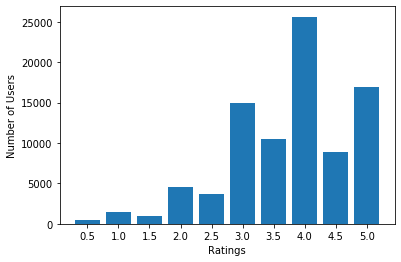

In [67]:
x=sample_ratings1['rating'].value_counts().rename_axis('ratings').reset_index(name='UserCount').sort_values(by=['ratings'])
plt.bar([i for i in range(10)], x['UserCount'])
plt.xticks([i for i in range(10)],x['ratings'])
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
plt.show()



# train-ALS function will train ALS model on train dataset using different hyperparameters regularization parameter and number of latent factors, and best model is the one which gives lowest value of RMSE on test dataset

In [8]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    colors=['b', 'g', 'r', 'c', 'm', 'y', 'k']
    min_RMSE = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    mae1=[]
    for i,rank in enumerate(ranks):
        mae=[]
        RMSE1=[]
        for reg in reg_param:
            als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", maxIter=num_iters, rank=rank,
                      regParam=reg,coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
            model = als.fit(train)
            evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
            evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
            test_predictions = model.transform(test)
            RMSE = evaluator.evaluate(test_predictions)
            MAE = evaluator1.evaluate(test_predictions)
            RMSE1.append(RMSE)
            mae.append(MAE)
            if RMSE < min_RMSE:
                min_RMSE = RMSE
                best_rank = rank
                best_regularization = reg
                best_model = model
        mae1.append(mae)
        plt.plot(reg_param, RMSE1,marker='o',color=colors[i],label='rank'+str(rank))
        
    plt.xlabel('regularization parameters')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    for i in range(len(mae1)):
        plt.plot(reg_param, mae1[i],marker='o',color=colors[i],label='rank'+str(ranks[i]))
    plt.xlabel('regularization parameters')
    plt.ylabel('MAE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

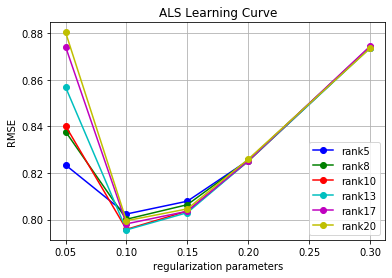

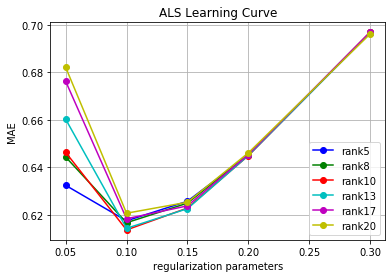


The best model has 13 latent factors and regularization = 0.1


In [9]:
(train, test) = ratings.randomSplit([0.8, 0.2], seed = 10)
best_model=train_ALS(train,test,10,[.05, .1, .15,0.2,0.3],[5,8,10,13,17,20])

# plot_learning_curve function will train ALS model on train dataset using different sizes of train and test data and best model is the one which gives lowest value of RMSE on test dataset, we also check MAE values on test data

In [10]:
def plot_learning_curve(split_ratio,data, reg, rank):
    rmse = []
    mae=[]
    for split in split_ratio:
        (train, test) = data.randomSplit([split, 1-split], seed = 10)
        als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", maxIter=10, rank=rank,
                      regParam=reg,coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
        model = als.fit(train)
        evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
        evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
        test_predictions = model.transform(test)
        RMSE = evaluator.evaluate(test_predictions)
        rmse.append(RMSE)
        MAE=evaluator1.evaluate(test_predictions)
        mae.append(MAE)
    plt.figure(figsize=(12, 6))
    plt.plot(split_ratio, rmse,marker='o',color='b')
    plt.xlabel('ratio of train size to total dataset')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()
    plt.figure(figsize=(12, 6))
    plt.plot(split_ratio, mae,marker='o',color='g')
    plt.xlabel('ratio of train size to total dataset')
    plt.ylabel('MAE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

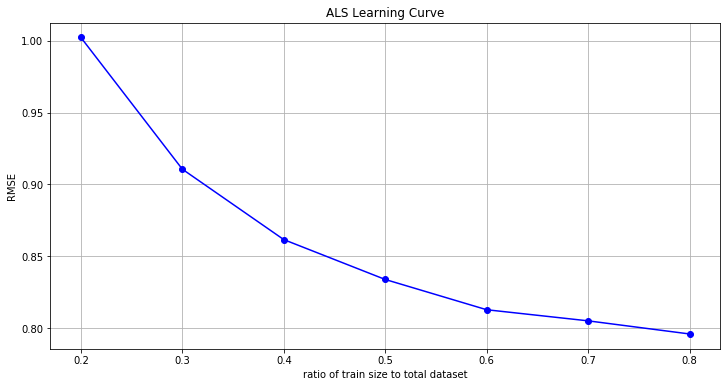

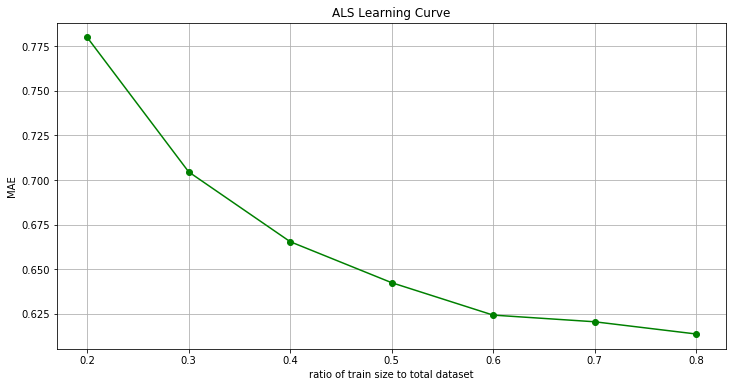

In [11]:
plot_learning_curve([0.2,0.3,0.4,0.5,0.6,0.7,0.8],ratings,reg=0.1,rank=13)

# Fitting the model for best set of hyperparameters


In [12]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

(train, test) = ratings.randomSplit([0.8, 0.2], seed = 10)
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", maxIter=10, rank=13,
                      regParam=0.1, coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)
model1=als.fit(train)

In [13]:
total_ratings = spark.read.csv('ml-20m/ratings.csv', inferSchema=True, header=True)
total_ratings = total_ratings.select(total_ratings.userId, total_ratings.movieId, total_ratings.rating)
total_ratings.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



# Model Evaluation

In [14]:
test_predictions1=model1.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(test_predictions1)
MAE = evaluator1.evaluate(test_predictions1)
print('The best model gives rmse value of {} and mae value of {} on test data'.format(RMSE,MAE))


The best model gives rmse value of 0.7957995955208711 and mae value of 0.6136809375604826 on test data


In [15]:
total_predictions = model1.transform(total_ratings)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(total_predictions)
MAE = evaluator1.evaluate(total_predictions)
print('The best model gives rmse value of {} and mae value of {} on total data'.format(RMSE,MAE))


The best model gives rmse value of 0.6727855814559194 and mae value of 0.5150906135343318 on total data


In [16]:
dict_movies={}
for i in range(len(movies)):
    dict_movies[movies['movieId'].iloc[i]]=movies['title'].iloc[i]

# Make top 10 movie recommendations for users 156 and 143 using model trained on sample 1

In [17]:
def make_recommendation(user,n_movies,model):
    userRecs = model.recommendForAllUsers(n_movies)
    userRecs_pandas=userRecs.toPandas()
    for i in range(len(userRecs_pandas)):
        for j in range(n_movies):
            userRecs_pandas['recommendations'].iloc[i][j]=list(userRecs_pandas['recommendations'].iloc[i][j])
    for i in range(len(userRecs_pandas)):
        for j in range(n_movies):
            userRecs_pandas['recommendations'].iloc[i][j][0]=dict_movies[userRecs_pandas['recommendations'].iloc[i][j][0]]
    x=list(userRecs_pandas.loc[userRecs_pandas['userId'] == user]['recommendations'])
    recommendation=[]
    for i in range(n_movies):
        recommendation.append(x[0][i][0])
    return recommendation


In [18]:
make_recommendation(156,10,model1)

['Shawshank Redemption, The (1994)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 "Schindler's List (1993)",
 'Godfather, The (1972)',
 'Silence of the Lambs, The (1991)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Usual Suspects, The (1995)',
 'Matrix, The (1999)',
 'Saving Private Ryan (1998)',
 'Sixth Sense, The (1999)']

In [19]:
make_recommendation(143,10,model1)

['Shawshank Redemption, The (1994)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Usual Suspects, The (1995)',
 "Schindler's List (1993)",
 'Godfather, The (1972)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)',
 'Fugitive, The (1993)',
 'Matrix, The (1999)',
 'Silence of the Lambs, The (1991)']

# User Coverage for k=10

In [20]:
def UserCoverage(model):
    userRecs = model.recommendForAllUsers(10)
    userRecs = userRecs.toPandas()
    count_user=0
    for i in range(len(userRecs)):
        count_movie=0
        for j in range(10):
            if userRecs['recommendations'].iloc[i][j][1]>=3.5:
                count_movie+=1
        if count_movie==10:
            count_user+=1
    user_coverage=count_user/len(userRecs)
    return user_coverage

In [21]:
UserCoverage(model1)

0.9176566460073118

# Item Coverage for k=10

In [22]:
def ItemCoverage(model):
    itemRecs = model.recommendForAllItems(10)
    itemRecs1 = itemRecs.toPandas()
    count_u=0
    for i in range(len(itemRecs1)):
        count_m=0
        for j in range(10):
            if itemRecs1['recommendations'].iloc[i][j][1]>=3.5:
                count_m+=1
        if count_m==10:
            count_u+=1
    item_coverage=count_u/len(itemRecs1)
    return item_coverage

In [23]:
ItemCoverage(model1)

1.0

# Catalog Coverage for k=10

In [24]:
def CatalogCoverage(model,data):
    userRecs = model.recommendForAllUsers(10)
    userRecs = userRecs.toPandas()
    l=[]
    for i in range(len(userRecs)):
        for j in range(10):
            l.append(userRecs['recommendations'].iloc[i][j][0])
    catalog_coverage=len(set(l))/data.toPandas()['movieId'].nunique()
    return catalog_coverage
    

In [26]:
CatalogCoverage(model1,ratings)

0.99

# Sample 2

In [28]:
ratings=pd.read_csv('ml-20m/ratings.csv')
movies_cnt = pd.DataFrame(ratings.groupby('movieId').size(), columns=['count'])
popularity_thres = 1000
popular_movies = list(set(movies_cnt.query('count >= @popularity_thres').index))
ratings_drop_movies = ratings[ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', ratings_drop_movies.shape)
# get number of ratings given by every user
users_cnt = pd.DataFrame(ratings_drop_movies.groupby('userId').size(), columns=['count'])
# filter data to come to an approximation of user likings.
ratings_thres = 1000
active_users = list(set(users_cnt.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of ratings data after dropping both unpopular movies and inactive users: ', ratings_drop_users.shape)

#Now randomly select 10% data after dropping unpopular movies and inactive users 
random.seed(9)
percent=0.1
index = np.random.permutation(len(ratings_drop_users))
num= int(percent*(len(ratings_drop_users)))
sample_index= index[:num]
sample_ratings2=ratings_drop_users.iloc[sample_index]
print(sample_ratings2.shape)
sample_ratings2.to_csv('sample_ratings2.csv')
print('size of sample 2: ', len(sample_ratings2))
ratings2 = spark.read.csv('sample_ratings2.csv', inferSchema=True, header=True)
ratings2.printSchema()
ratings2 = ratings2.select(ratings2.userId, ratings2.movieId, ratings2.rating)


shape of original ratings data:  (20000263, 4)
shape of ratings data after dropping unpopular movies:  (17765516, 4)
shape of ratings data after dropping both unpopular movies and inactive users:  (1205777, 4)
(120577, 4)
size of sample 2:  120577
root
 |-- _c0: integer (nullable = true)
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



# Sparsity of data


In [29]:
numerator = ratings2.select("rating").count()

num_users = ratings2.select("userId").distinct().count()
num_movies = ratings2.select("movieId").distinct().count()

denominator = num_users * num_movies

sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  95.94% empty.


In [30]:
print("Movie with the fewest ratings: ")
ratings2.groupBy("movieId").count().select(min("count")).show()

print("Avg num ratings per movie: ")
ratings2.groupBy("movieId").count().select(avg("count")).show()

print("User with the fewest ratings: ")
ratings2.groupBy("userId").count().select(min("count")).show()

print("Avg num ratings per user: ")
ratings2.groupBy("userId").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         4|
+----------+

Avg num ratings per movie: 
+-----------------+
|       avg(count)|
+-----------------+
|38.16935739157962|
+-----------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|        74|
+----------+

Avg num ratings per user: 
+------------------+
|        avg(count)|
+------------------+
|128.13708820403826|
+------------------+



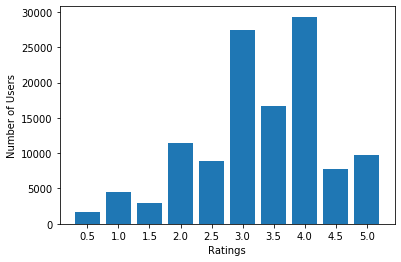

In [31]:
x=sample_ratings2['rating'].value_counts().rename_axis('ratings').reset_index(name='UserCount').sort_values(by=['ratings'])
plt.bar([i for i in range(10)], x['UserCount'])
plt.xticks([i for i in range(10)],x['ratings'])
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
plt.show()



In [32]:
(train, test) = ratings2.randomSplit([0.8, 0.2], seed = 10)


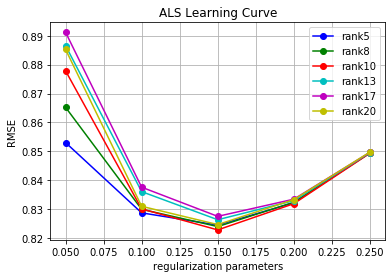

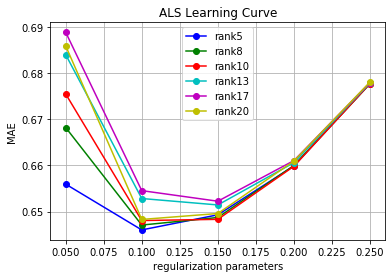


The best model has 10 latent factors and regularization = 0.15


In [33]:
best_model=train_ALS(train,test,10,[.05, .1, .15,0.2,0.25],[5,8,10,13,17,20])

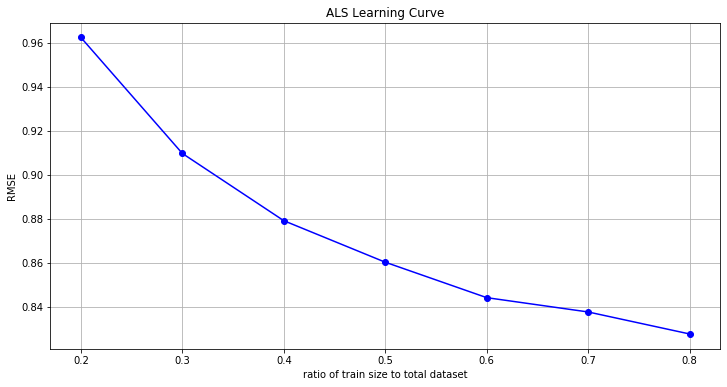

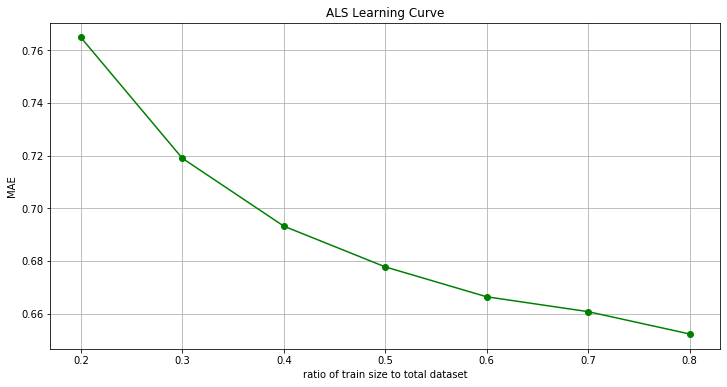

In [34]:
plot_learning_curve([0.2,0.3,0.4,0.5,0.6,0.7,0.8],ratings2,0.15,10)

In [35]:
(train, test) = ratings2.randomSplit([0.8, 0.2], seed = 10)
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", maxIter=10, rank=10,
                      regParam=0.15,coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [36]:
model2=als.fit(train)

In [37]:
test_predictions2=model2.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(test_predictions2)
MAE = evaluator1.evaluate(test_predictions2)
print('The best model gives rmse value of {} and mae value of {} on test data'.format(RMSE,MAE))


The best model gives rmse value of 0.827519001958868 and mae value of 0.6522384939989317 on test data


In [38]:
total_predictions = model2.transform(total_ratings)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(total_predictions)
MAE = evaluator1.evaluate(total_predictions)
print('The best model gives rmse value of {} and mae value of {} on total data'.format(RMSE,MAE))


The best model gives rmse value of 0.8157045318782896 and mae value of 0.6416658247709109 on total data


# Make recommendations for user 156 using model trained on sample 2

In [39]:
make_recommendation(156,10,model2)

['Shawshank Redemption, The (1994)',
 'Secret in Their Eyes, The (El secreto de sus ojos) (2009)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Band of Brothers (2001)',
 'Gone Girl (2014)',
 'Dark Knight, The (2008)',
 'Best Years of Our Lives, The (1946)',
 "Pan's Labyrinth (Laberinto del fauno, El) (2006)",
 'Rear Window (1954)']

# User Coverage for k=10


In [40]:
UserCoverage(model2)

0.9373007438894793

 # Item Coverage for k=10


In [41]:
ItemCoverage(model2)

0.7534029756251979

# Catalog Coverage for k=10


In [42]:
CatalogCoverage(model2,ratings2)

0.6681323203545426

# Sample 3

In [43]:
#remove unpopular movies and movies with more than 20000 movies
ratings=pd.read_csv('ml-20m/ratings.csv')
index=ratings['movieId'].value_counts().rename_axis('movieId').reset_index(name='count')[:1000]
ind=index.loc[index['count']<=20000]
# filter data to come to an approximation of user likings.
ratings_thres = 1000
active_users = list(set(ind.query('count >= @ratings_thres').index))
ratings_drop_users = ratings_drop_movies[ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ',ratings.shape)
random.seed(9)
percent=0.4
index = np.random.permutation(len(ratings_drop_users))
num= int(percent*(len(ratings_drop_users)))
sample_index= index[:num]
sample_ratings3=ratings_drop_users.iloc[sample_index]
print('size of sample 3: ', len(sample_ratings3))
sample_ratings3.to_csv('sample_ratings3.csv')

shape of original ratings data:  (20000263, 4)
size of sample 3:  44784


In [44]:
ratings3 = spark.read.csv('sample_ratings3.csv', inferSchema=True, header=True)
ratings3 = ratings3.select(ratings3.userId, ratings3.movieId, ratings3.rating)
ratings3.printSchema()


root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



In [45]:
print("Movie with the fewest ratings: ")
ratings3.groupBy("movieId").count().select(min("count")).show()

print("Avg num ratings per movie: ")
ratings3.groupBy("movieId").count().select(avg("count")).show()

print("User with the fewest ratings: ")
ratings3.groupBy("userId").count().select(min("count")).show()

print("Avg num ratings per user: ")
ratings3.groupBy("userId").count().select(avg("count")).show()

Movie with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         1|
+----------+

Avg num ratings per movie: 
+------------------+
|        avg(count)|
+------------------+
|14.294286626236834|
+------------------+

User with the fewest ratings: 
+----------+
|min(count)|
+----------+
|         4|
+----------+

Avg num ratings per user: 
+-----------------+
|       avg(count)|
+-----------------+
|53.25089179548157|
+-----------------+



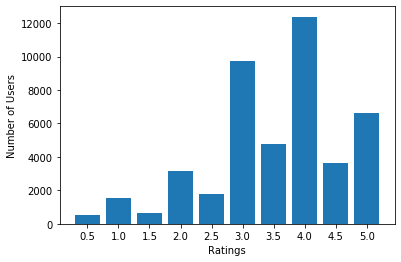

In [46]:
x=sample_ratings3['rating'].value_counts().rename_axis('ratings').reset_index(name='UserCount').sort_values(by=['ratings'])
plt.bar([i for i in range(10)], x['UserCount'])
plt.xticks([i for i in range(10)],x['ratings'])
plt.xlabel("Ratings")
plt.ylabel("Number of Users")
plt.show()



# Sparsity of data


In [47]:
numerator = ratings3.select("rating").count()

num_users = ratings3.select("userId").distinct().count()
num_movies = ratings3.select("movieId").distinct().count()

denominator = num_users * num_movies

sparsity = (1.0 - (numerator *1.0)/denominator)*100
print("The ratings dataframe is ", "%.2f" % sparsity + "% empty.")

The ratings dataframe is  98.30% empty.


In [48]:
ratings3.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)



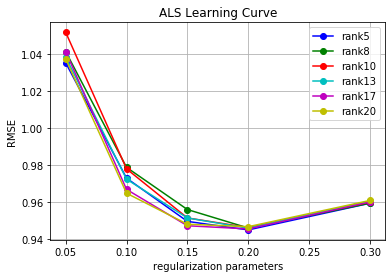

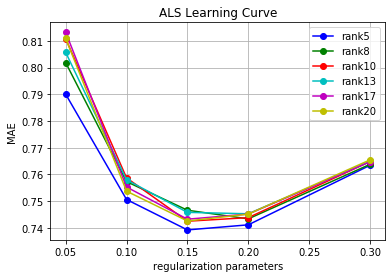


The best model has 5 latent factors and regularization = 0.2


In [49]:
(train, test) = ratings3.randomSplit([0.8, 0.2], seed = 10)
best_model=train_ALS(train,test,10,[.05, .1, .15,0.2,0.3],[5,8,10,13,17,20])

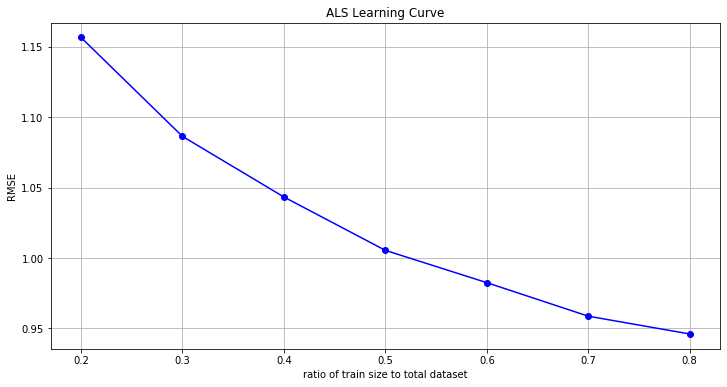

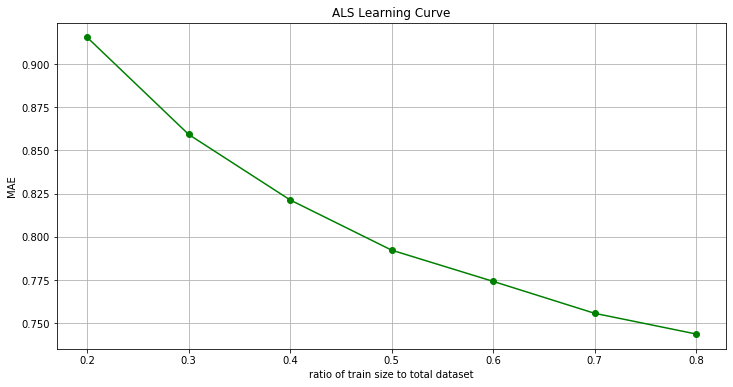

In [50]:
plot_learning_curve([0.2,0.3,0.4,0.5,0.6,0.7,0.8],ratings3,0.2,5)

In [51]:
(train, test) = ratings3.randomSplit([0.8, 0.2], seed = 10)
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", maxIter=10, rank=5,
                      regParam=0.2,coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

In [52]:
model3=als.fit(train)

In [53]:
test_predictions3=model3.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction") 
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(test_predictions3)
MAE = evaluator1.evaluate(test_predictions3)
print('The best model gives rmse value of {} and mae value of {} on test data'.format(RMSE,MAE))


The best model gives rmse value of 0.9460292189288629 and mae value of 0.7438098444059938 on test data


In [54]:
total_predictions = model3.transform(total_ratings)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator1 = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction") 
RMSE = evaluator.evaluate(total_predictions)
MAE = evaluator1.evaluate(total_predictions)
print('The best model gives rmse value of {} and mae value of {} on total data'.format(RMSE,MAE))


The best model gives rmse value of 0.8630916698499965 and mae value of 0.6742902436482574 on total data


# Make recommendations for user 717 using model trained on sample 3

In [55]:
make_recommendation(717,10,model3)

['Chungking Express (Chung Hing sam lam) (1994)',
 'Hope and Glory (1987)',
 'Bicycle Thieves (a.k.a. The Bicycle Thief) (a.k.a. The Bicycle Thieves) (Ladri di biciclette) (1948)',
 'Raise the Red Lantern (Da hong deng long gao gao gua) (1991)',
 'Squid and the Whale, The (2005)',
 'Gaslight (1944)',
 'Spellbound (2002)',
 'Doctor Zhivago (1965)',
 'Gosford Park (2001)',
 'Beauty of the Day (Belle de jour) (1967)']

# User Coverage for k=10


In [56]:
UserCoverage(model3)

0.9655172413793104

# Item Coverage for k=10


In [57]:
ItemCoverage(model3)

0.8169195996125282

# Catalog Coverage for k=10


In [59]:
CatalogCoverage(model3,ratings3)

0.7185221832109799

# Results

In [75]:
results=pd.DataFrame(columns=['sample_number','rmse','mae','user_coverage','item_coverage','catalog_coverage'])

results['sample_number']=[1,2,3]
results['rmse']=[evaluator.evaluate(test_predictions1),evaluator.evaluate(test_predictions2),evaluator.evaluate(test_predictions3)]
results['mae']=[evaluator1.evaluate(test_predictions1),evaluator1.evaluate(test_predictions2),evaluator1.evaluate(test_predictions3)]
results['user_coverage']=[UserCoverage(model1),UserCoverage(model2),UserCoverage(model3)]
results['item_coverage']=[ItemCoverage(model1),ItemCoverage(model2),ItemCoverage(model3)]
results['catalog_coverage']=[CatalogCoverage(model1,ratings),CatalogCoverage(model2,ratings2),CatalogCoverage(model3,ratings3)]


In [76]:
results

,sample_number,rmse,mae,user_coverage,item_coverage,catalog_coverage
0,1,0.795800,0.613681,0.917657,1.000000,0.990000
1,2,0.827519,0.652238,0.937301,0.753403,0.668132
2,3,0.946029,0.743810,0.965517,0.816920,0.718522
